# TODO:
1. Split forward and backward pass into multiple cells and pretty print
2. Unkok
3. Add math explanations to forward and backward pass
4. Draw the network architecture in drawio
5. Make data generator
6. Do multiple forward and backward passes automatically
7. Save trained network parameters as an introductory example


# Problem formulation
The problem at hand is a binary classification task between two tetris pieces, the "I" and the "O". These pieces were chosen since they neatly represent "1" and "0" graphically (which will be their embedding in this problem). To classify images with "I" or "O" in them, images in the form of 4x4x1 matrices are fed to a CNN+FCNN, the performance of which is determined with binary cross-entropy and trained using stochastic gradient descent.

# Given
1. The network architecture  

| **Layer**   | **Input dim** | **Output dim** | **Other**                                                  |
|-------------|---------------|----------------|------------------------------------------------------------|
| Input       | 4x4           | 4x4            | "I" or "O" in input                                        |
| 2D convolve | 4x4           | 3x3            | Kernel: 2x2 with stride 1 and no padding. Activation: ReLU |
| Max pool    | 3x3           | 2x2            | Kernel: 2x2 with stride 1 and no padding.                  |
| Flatten     | 2x2           | 4x1            |                                                            |
| FCNN        | 4x1           | 1              | Activation: Sigmoid                                        |

which has a total of 10 parameters, decomposed into 2 biases from the CNN and FCNN, 4 kernel weights in the CNN and 4 weights in the FCNN.

2. An input matrix *X* and a label *y*, where *y* = 0 when *X* contains "O" and *y* = 1 when *X* contains "I"

# Find
1. The intermediate values in the network
2. Post-activation for a forward pass
3. Loss for a forward pass
3. Gradient of the loss function w.r.t. the network parameters


# Imports and helper functions

In [627]:
import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass

from __future__ import annotations
from itertools import product


class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.data: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, val):
        self.data[key] = val

    def __gt__(self, other):
        return self.data > other

    
    def __lt__(self, other):
        return self.data < other


    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.data, cmap=plt.cm.Blues)

        if self.nrow == 1:
            for col in range(self.ncol):
                ax.text(col, 0, f"{self.data[0, col]:.2f}", va='center', ha='center')
        elif self.ncol == 1:
            for row in range(self.nrow):
                ax.text(0, row, f"{self.data[row, 0]:.2f}", va='center', ha='center')
        else:
            for col, row in np.ndindex(self.data.shape):
                ax.text(col, row, f"{self.data[row, col]:.2f}", va='center', ha='center')


        ax.set_title(title)


    # TODO: Fix padding
    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        """Convolve the 2D matrix with a 2D kernel plus bias

        See http://www.songho.ca/dsp/convolution/convolution2d_example.html for the math
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.data[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.data.flatten() \
                + bias 

        return Matrix2D(output_image)

    def maxpool(self, ndim: int = 1, stride: int = 1):
        """Dimension reduction using the max of a neigborhood defined by ndim

        See https://computersciencewiki.org/index.php/Max-pooling_/_Pooling for the math
        and https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers
        for the intuition on why the indices of the maximum values for each pool is needed
        """
        output_width: int = (self.nrow - ndim) // stride + 1
        output_height: int = (self.ncol - ndim) // stride + 1

        output_image = np.zeros((output_height, output_width))
        indices = []

        for row, col in product(range(output_width), range(output_height)):
            rows = slice(row * ndim, (row+1) * ndim)
            cols = slice(col * ndim, (col+1) * ndim)
            pool = self.data[rows, cols]

            output_image[row, col] = np.max(pool)

            index = np.add(np.unravel_index(np.argmax(pool), pool.shape), (row * col, col * row))
            indices.append(index)
        
        return Matrix2D(output_image), indices

    def flatten(self):
        return Matrix2D(self.data.flatten().reshape(self.nrow*self.ncol, 1))



# TODO: Make compatible with arrays and matrices?
# TODO: Alternatively remove class and just pass bool
@dataclass
class Network():
    weights: np.ndarray = np.empty(0)
    bias: float = 0.0
    backward: bool = False

    def forward(self, x):
        return self.weights @ x + self.bias

    def relu(self, value):
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * value

    def sigmoid(self, value):
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act

    def binary_cross_entropy(self, y: float, p: float) -> float:
        """Binary cross entropy loss calculation

        See: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
        """
        if self.backward:
            return (1 - y) / (1 - p) - (y / p)

        return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))



#Data 
# K = Matrix2D(np.array(([[1, 1], [1, 1]])))
# I = Matrix2D(np.zeros((4, 4)))
# I[:4, 2] = 1
# I.draw("Example image of I block")
# IC = I.convolve2D(K)
# IC.draw("Convolved I block")


# IM = IC.maxpool(2, 1)
# IM.draw("Maxpooled I block")


# O = Matrix2D(np.zeros((4, 4)))
# O[1:3, 1:3] = 1
# O.draw("Example image of O block")
# OM = O.maxpool(2, 2)
# OM.draw("Maxpooled O block")



# Initialize parameters

In [628]:

# Learned parameters
K = Matrix2D(np.array(([[1, -1], [-1, 1]]),  dtype=np.float64))
w = np.random.uniform(low=-1, high=1, size=(1, 4))

b1 = 1.0
b2 = 1.0

nn = Network(weights=w, bias = b2)


# Data

y = 1


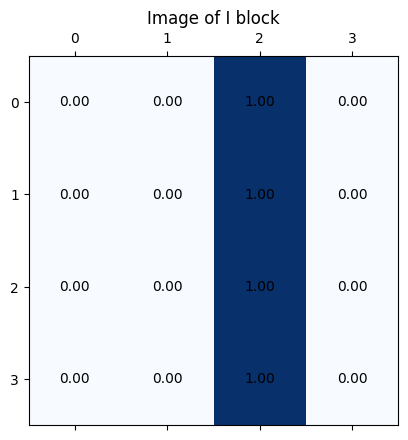

In [629]:
# DATA
X = Matrix2D(np.zeros((4, 4)))
X[:4, 2] = 1
y = 1 #"O" = 0 and "I" = 1
print(f"y = {y}")
X.draw("Image of I block")

# X = Matrix2D(np.zeros((4, 4)))
# X[1:3, 1:3] = 1
# y = 0
# X.draw("Example image of O block")

# Forward pass

CNN: [ 1. -1. -1.  1.], 1.0. FCNN: [-0.094536   -0.30624018  0.19630665  0.21087297], 1.0
z4 = nn.forward(a3) = 1.006403438661735 
a4 = nn.sigmoid(z4) = 0.7323157067806868
loss = nn.binary_cross_entropy(y, a4) = 0.13530165097167343


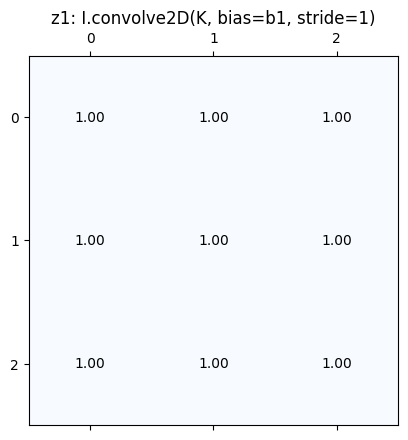

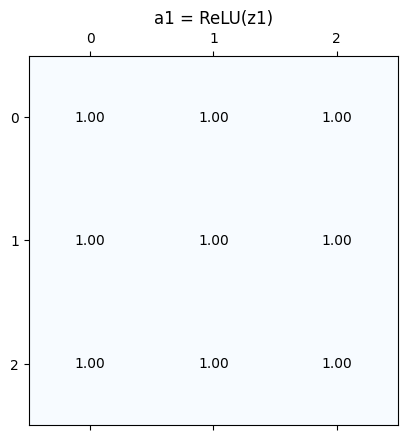

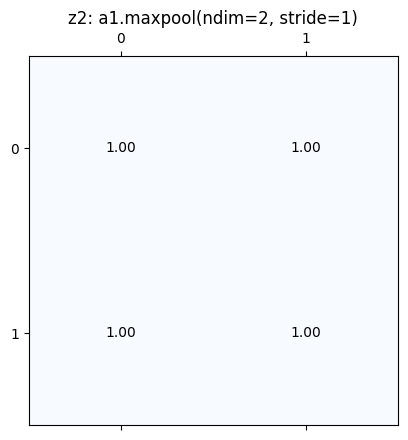

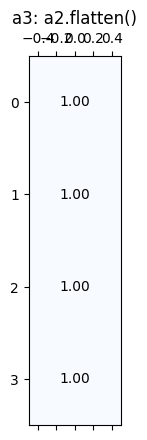

In [630]:
# z: pre-activation variable
# a: post-activation variable
print(f"CNN: {K.data.flatten()}, {b1}. FCNN: {nn.weights[0]}, {nn.bias}")

nn.backward = False

z1 = X.convolve2D(K, bias=b1, stride=1)
z1.draw("z1: I.convolve2D(K, bias=b1, stride=1)")

a1 = Matrix2D(nn.relu(z1.data))
a1.draw("a1 = ReLU(z1)")

a2, maxpool_indices = a1.maxpool(ndim=2, stride=1)
a2.draw("z2: a1.maxpool(ndim=2, stride=1)")

a3: Matrix2D = a2.flatten()
a3.draw("a3: a2.flatten()")

z4: float = nn.forward(a3.data)[0, 0]
print(f"z4 = nn.forward(a3) = {z4} ")

a4 = nn.sigmoid(z4)
print(f"a4 = nn.sigmoid(z4) = {a4}")

l = nn.binary_cross_entropy(y, a4)
print(f"loss = nn.binary_cross_entropy(y, a4) = {l}")


# Backward pass

In [631]:
learning_rate = 0.2

nn.backward = True # Make sure to set the network to backward pass now

# Chain rule backwards in the network
delta = nn.binary_cross_entropy(y, a4) * nn.sigmoid(z4)
nn.bias -= learning_rate * delta # Update bias for the FCNN

delta = delta * a3.data 
nn.weights -= learning_rate * delta.T # Update weights for the FCNN


# Undo the flattening operation
#delta = delta.reshape(a2.data.shape)

# Calculate the derivative through the maxpool operation
delta_temp = np.zeros_like(a1.data)
for max_indices, gradient in zip(maxpool_indices, delta):
    delta_temp[max_indices] = gradient
delta = delta_temp

# Derivative through the ReLU activation
#Matrix2D(delta).draw()
delta = nn.relu(delta) * delta
#Matrix2D(delta).draw()

# Derivative through the convolution operation
grad_b1 = delta.sum()
grad_kernel = X.convolve2D(Matrix2D(delta))


# Update weights and biase for convolution
K.data -= learning_rate * grad_kernel.data
b1 -= learning_rate * grad_b1


